In [91]:
import tensorflow as tf
import tensorflow_probability as tfp
from PIL import Image
from tensorboard.backend.event_processing import event_accumulator

tfd = tfp.distributions
tfb = tfp.bijectors

import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from pathlib import Path
import sys

sys.path += ['../']
from chains import *
from utils import postprocess, preprocess, load_model, pack, latest_weights

from IPython.display import display, Markdown

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True)

In [3]:
runs = {
    'RealNVP from assignment': 'logs/natural-imposing-petrel-of-art/',
    'RealNVP multiscale': 'logs/outrageous-cuddly-vicugna-of-masquerade/',
    'Glow from assignment': 'logs/magic-burrowing-badger-of-serenity/',
    'Glow multiscale': 'logs/meek-flawless-cougar-of-elegance/'
}

## Bits/dim plots

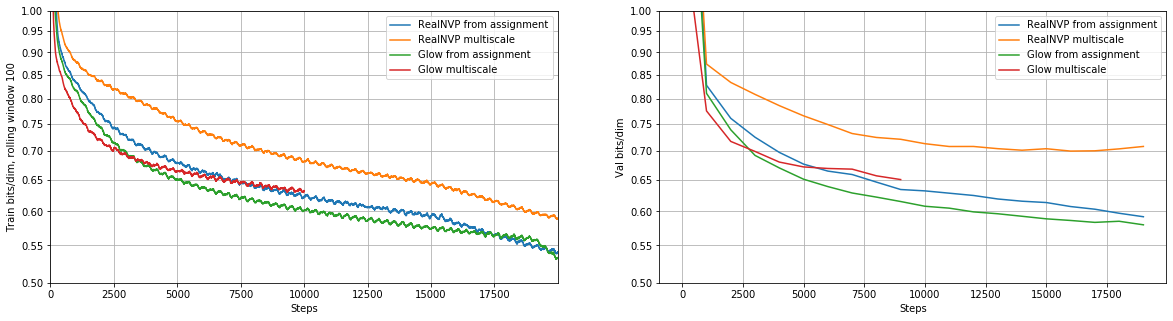

In [143]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))

for run_name, logdir in runs.items():
    train_events = event_accumulator.EventAccumulator(logdir + '/train',
                                                      size_guidance={'tensors': 0}).Reload()
    val_events = event_accumulator.EventAccumulator(logdir + '/val',
                                                    size_guidance={'tensors': 0}).Reload()

    get_bitsdim = lambda x: pd.Series({event.step: tf.make_ndarray(event.tensor_proto) for event in x.tensors.Items('bits/dim')})
    train_bitsdim, val_bitsdim = map(get_bitsdim, [train_events, val_events])

    train_bitsdim.rolling(100).mean().plot(label=f'{run_name}', ax=axes[0])
    axes[1].plot(val_bitsdim, label=f'{run_name}')
    
axes[0].legend()
axes[0].set_ylabel('Train bits/dim, rolling window 100')
axes[0].set_xlabel('Steps')
axes[0].set_yscale('log')
axes[0].set_yticks(np.arange(5e-1, 1.1, 0.05), minor=False)
axes[0].set_yticklabels([f'{n:0.2f}' for n in np.arange(5e-1, 1.1, 0.05)])
axes[0].set_ylim(0.5, 1.0)
axes[0].grid(True)
axes[1].legend()
axes[1].set_ylabel('Val bits/dim')
axes[1].set_xlabel('Steps')
axes[1].set_yscale('log')
axes[1].set_yticks(np.arange(5e-1, 1.1, 0.05))
axes[1].set_yticklabels([f'{n:0.2f}' for n in np.arange(5e-1, 1.1, 0.05)])
axes[1].grid(True)
axes[1].set_ylim(0.5, 1.0);

## Samples and interpolations with T=0.7

In [2]:
def plot_samples(model, T, rows, columns):
    z = model.distribution.sample([rows * columns, 32 * 32 * 3]) * T
    s = model.bijector.forward(z)
    s = postprocess(s, n_bits=2.)
    s = pack(s.numpy(), rows)
    plt.figure(figsize=(rows, columns))
    plt.imshow(s[..., ::-1])
    plt.axis('off')
    
def plot_interpolated_samples(model, T, pairs, interpolation_points):
    z = model.distribution.sample([10, 32 * 32 * 3]) * 0.7
    alphas = np.broadcast_to(np.arange(0, 1.1, 0.1, dtype=np.float32)[np.newaxis, :, np.newaxis], [5, 11, 3072])
    z = np.broadcast_to(z[:, np.newaxis, :], [z.shape[0], 11, *z.shape[1:]])
    interp_z = alphas * norman_z[:5] + (1 - alphas) * z[5:]
    interp_samples = model.bijector.forward(interp_z.reshape((-1, 3072))).numpy().reshape((5, 11, 32, 32, 3))

    interp_samples = postprocess(interp_samples, n_bits=2.)
    interp_samples = pack(interp_samples.numpy(), 5, first_reshape=False)

    plt.figure(figsize=(10, 10))
    plt.imshow(interp_samples[..., ::-1])
    plt.axis('off')    

### Model: RealNVP from assignment

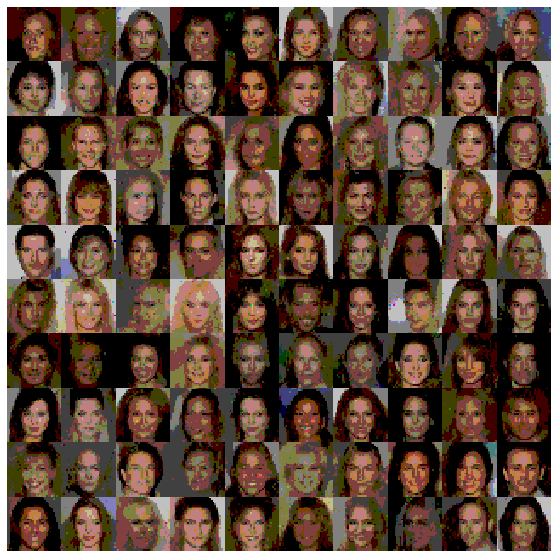

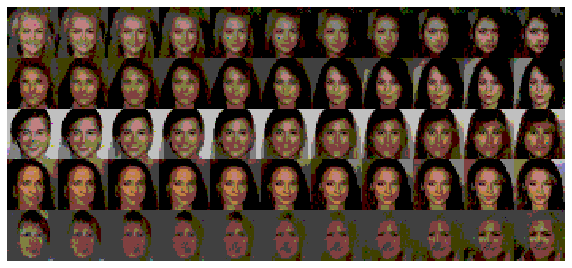

### Model: RealNVP multiscale

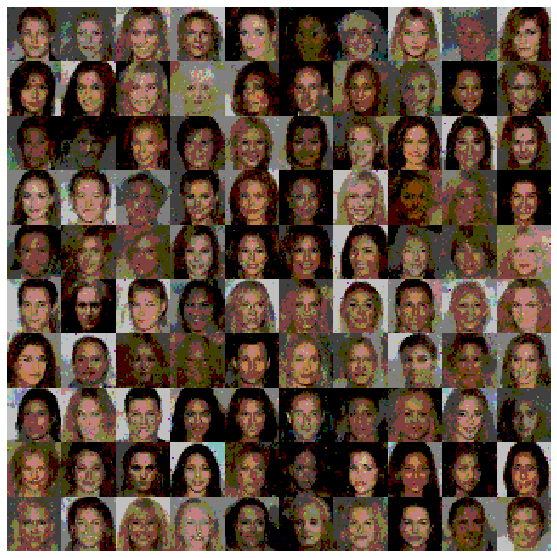

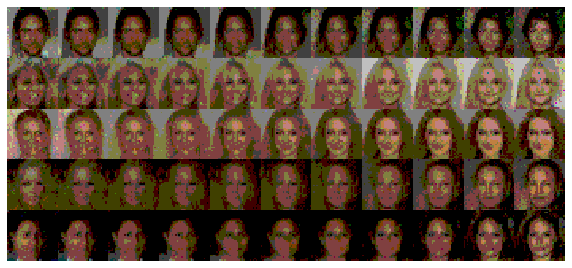

### Model: Glow from assignment

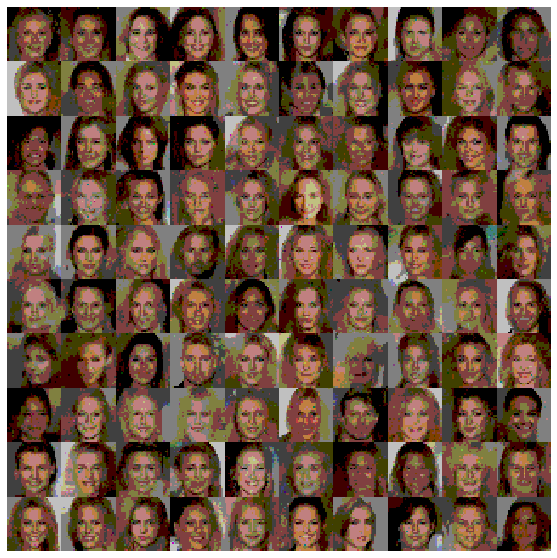

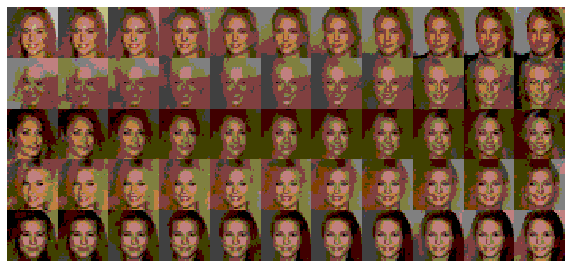

### Model: Glow multiscale

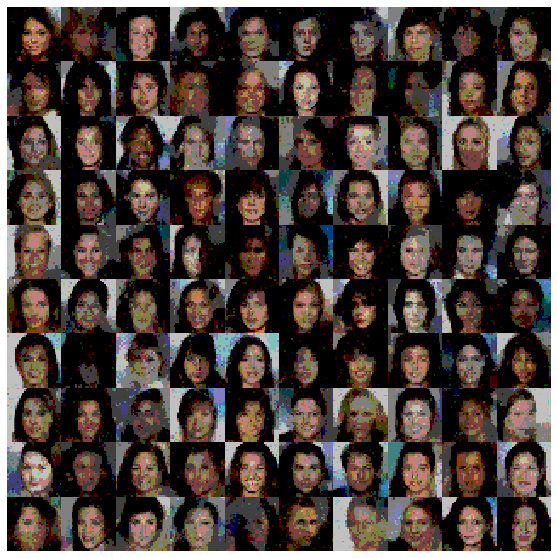

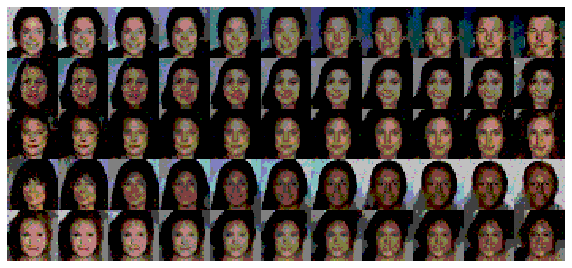

In [14]:
for run_name, logdir in runs.items():
    tf.keras.backend.clear_session()
    model = load_model(Path(logdir) / 'args.json', latest_weights(logdir))
    display(Markdown(f'### Model: {run_name}'))
    plot_samples(model, T=0.7, rows=10, columns=10)
    plt.show()
    plot_interpolated_samples(model, T=0.7, pairs=5, interpolation_points=11)
    plt.show()